In [1]:
import tensorflow as tf
tf.__version__

'2.8.0'

Neden Transfer Learning kullanıyoruz ?

* Benzer problemlerde basarisini kanitlamis olan olan ag mimarilerini(network architecture) kullanmak gayet mantikli. 
* Benzer veri kumesi ile calismis ve halihazirda benzer verideki oruntuleri ogrenmis bir ag isimize elbet yarar. Ayrica daha az veri ile daha iyi sonuclar elde  etmemizi saglar.


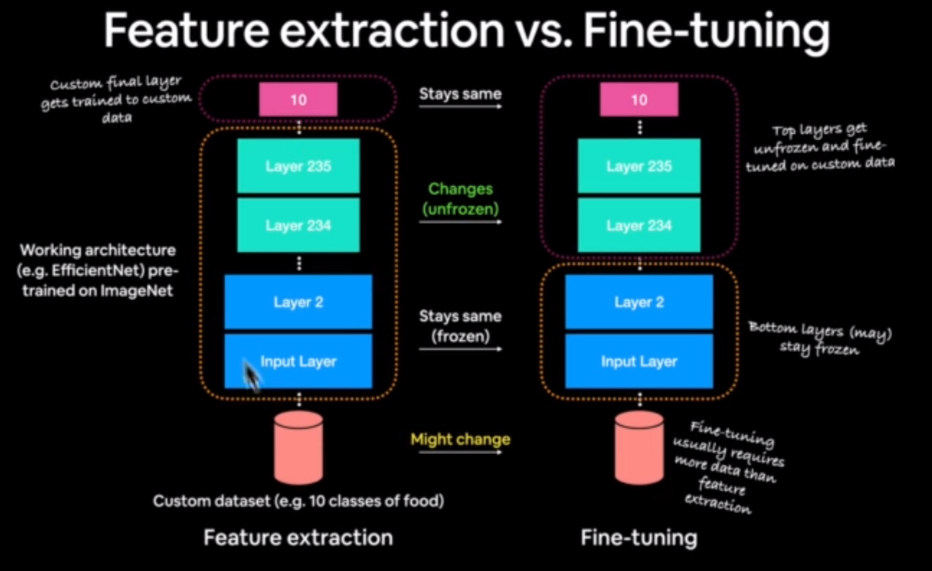

Fine-Tuning de Feature Extraction dan farkli olarak bazi ag katmanlarini verimiz ile ince ayarlamalar yapmak icin kullanacagiz.

#### ----------

Daha once yazmis oldugumuz yardimci fonksiyonlari kullanalim.

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2022-03-13 15:04:52--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-03-13 15:04:52 (66.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



Fonksiyonlari dahil edelim

In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

https://www.tensorflow.org/api_docs/python/tf/keras/applications

Verimizin sadece %10 unu kullanrak gerceklestirecegiz.

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2022-03-13 15:04:53--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  59.8MB/s    in 2.7s    

2022-03-13 15:04:56 (59.8 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



Verinin dizinlerine goz atalim

In [5]:
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [6]:
#dizinleri tanimlayalim
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

bu sefer ImageDataGenerator yerine mage_dataset_from_directory kullanacagiz

In [7]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

verimiz BatchDataset sekline donustu bu kullandigimiz fonksiyon ile ilgili. Bu fonksiyon verimizi dogrudan batch ler halina getirdi.

In [9]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

###  Functional API Kullanarak Model Olusturma

Sequential API vs Functional API farkini anlamak adina bir guuggle search 
SeqAPI biraz daha duz bir sekilde islerken, FuncAPI daha rahat hareket etmenizi saglar. Bodoslama farki bu.

### model_0

In [10]:
 # 1. tf.keras.applications kullanarak base_model(temel model) tanimlayalim
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. temel modelimizi donduruyoruz cunku egitim esnasinda ogrenilmis olan oruntuleri tekrar guncellemek istemiyoruz
base_model.trainable = False 

# 3. girdi katmani 
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. ResNet50V2 gibi modellerde girdileri normalize etmemiz gerekir (EfficientNet(s) te gerekmiyor)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. girdilerimizi base_model e gecirelim
x = base_model(inputs)
print(f"inputlar modele gectikten sonra shape'i: {x.shape}")

# 6. Average pool ile base_model ciktilarina pooling uygulayalim (tum onemli bilgileri toplar, hesaplama sayisini dusurur)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"GlobalAveragePooling2D'den sonra shape'imiz: {x.shape}")

# 7. aktivasyon katmanini olusuturalim
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. input ve outputlari birlestirelim 
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model 
#modelin gelismini kaydedelim (tensorboard ile)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25 * len(test_data)),
                                 callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                        experiment_name= '10_percent_feature_extraction')]
                                 )

16719872/16705208 [==============================] - 0s 0us/step
inputlar modele gectikten sonra shape'i: (None, 7, 7, 1280)
GlobalAveragePooling2D'den sonra shape'imiz: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20220313-150512
Epoch 1/5
24/24 [==============================] - 30s 455ms/step - loss: 1.9451 - accuracy: 0.3960 - val_loss: 1.3614 - val_accuracy: 0.6924
Epoch 2/5
24/24 [==============================] - 10s 387ms/step - loss: 1.1699 - accuracy: 0.7280 - val_loss: 0.9238 - val_accuracy: 0.7944
Epoch 3/5
24/24 [==============================] - 7s 272ms/step - loss: 0.8681 - accuracy: 0.8013 - val_loss: 0.7225 - val_accuracy: 0.8207
Epoch 4/5
24/24 [==============================] - 7s 268ms/step - loss: 0.6957 - accuracy: 0.8413 - val_loss: 0.6517 - val_accuracy: 0.8388
Epoch 5/5
24/24 [==============================] - 9s 359ms/step - loss: 0.6031 - accuracy: 0.8680 - val_loss: 0.5845 - val_accuracy: 0.8438


**Evaluate-** Modeli tum test kumesinde degerlendirelim.

In [11]:
model_0.evaluate(test_data)

79/79 [==============================] - 12s 140ms/step - loss: 0.6166 - accuracy: 0.8340


[0.6165832877159119, 0.8339999914169312]

base_model in katmanlarina gozatalim

In [12]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [13]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

Peki tum modele bakalim

In [14]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


Modelin egitim surecine bakalim

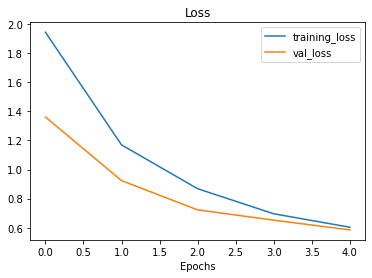

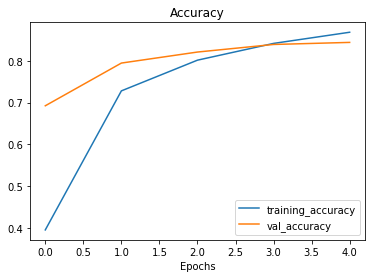

In [15]:
plot_loss_curves(history_10_percent)

training ve validation grafikte birlikte hareket ediyor bizim tam da istiyecegimiz sey

### Feature Vector
Teorik olarak arastirilmali ornek uzerinden bakalim neymis. Basitce bir ozellik tasiyan vectorler.

In [16]:
input_shape = (1, 4, 4, 3)

#rastgele tensorler olusturalim
input_tensor = tf.random.normal(input_shape)

input_tensor

<tf.Tensor: shape=(1, 4, 4, 3), dtype=float32, numpy=
array([[[[ 0.5996978 , -0.6950344 , -0.84217066],
         [-0.8221295 , -2.1030805 , -0.14571357],
         [-0.5210561 , -1.3010452 ,  0.3575075 ],
         [ 0.4954096 , -0.44256073, -1.0171046 ]],

        [[-0.53761715, -2.3315184 ,  0.72234434],
         [-1.1116668 , -0.6090858 ,  0.18019375],
         [-1.2529017 ,  0.54824245, -1.9733698 ],
         [ 0.05984373, -0.31358472,  1.3116649 ]],

        [[ 0.1878866 , -1.0914342 , -2.0335774 ],
         [ 1.6375517 , -1.6863159 ,  1.7278016 ],
         [ 1.0697094 ,  0.35645014, -1.1214802 ],
         [ 1.587785  ,  1.757776  ,  1.2509987 ]],

        [[ 0.25589067,  1.0982351 ,  0.9219425 ],
         [ 0.75667644,  0.21105282,  0.7689348 ],
         [-0.06934669,  1.9241595 ,  0.18307151],
         [ 0.6936572 ,  1.0139621 , -0.6306673 ]]]], dtype=float32)>

Bu tensore GlobalAveragePooling islemini uygulayalim

In [17]:
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
global_average_pooled_tensor

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[ 0.1893369 , -0.22898635, -0.0212265 ]], dtype=float32)>

Goruldugu gibi shape i azaldi. Sayilar kaybolmadi. Feature Vector dedigimiz sey vektorel bir temsilmis. Daha dusuk shape sahip bir temsili olusumus oldu.
**Pooling** boyle bisey. Farkli bir yolla taklit edelim aynisini.

Basitce Feature Vector modelin anlayacagi  sekilde input verisinin sikistirilim bir temsilidir.

In [18]:
tf.reduce_mean(input_tensor, axis=[1,2]) #1 ve 2. axis dekini ortalama ile azaltcak yani ayni islemi yapacak

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[ 0.1893369 , -0.22898635, -0.0212265 ]], dtype=float32)>

## Deneyimleyelim

1. **model_1** - verinin %1 i ile feature exraction transfer learning ve data augmentation kullanarak...
2. **model_2**- verinin  %10 u ile feature exraction transfer learning ve data augmentation kullanarak...
3. **model_3** - verinin %10 u ile fine-tuning transfer learning ve data augmentation kullanarak...
4. **model_4** - verinin %100 u ile fine-tuning transfer learning ve data augmentation kullanarak...
 
 
 **Not:** Tum testler ayni veri kumesi ile yapilacaktir.

### model_1

Veriyi alalim

In [19]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip 
unzip_data("10_food_classes_1_percent.zip")

--2022-03-13 15:06:51--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  65.3MB/s    in 2.0s    

2022-03-13 15:06:54 (65.3 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



Dosya konumlarini olusturalim

In [20]:
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

ne kadar verimiz var kontrol edelim

In [21]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'

Verilerimizi hazirliyalim

In [22]:
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE) # default = 32

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


 ### **Data Augmentation** :
  ImageDataGenerator yerine modele dogrudan katman olarak ekleyecegiz. Bunu kataman olarak ekeldigimizde augmentation islemi GPU uzerinde gerceklesmis olacak ve bu bize zaman kazandirir. Bunun gibi birsuru avantaj saglayacaktir. Arastirilsin.

In [23]:
import tensorflow as tf
from tensorflow import keras



# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential([
  
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomHeight(0.2),
  tf.keras.layers.RandomWidth(0.2),
  #tf.keras.layers.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

Simdi bu arttirilmis (augmented)verilere bakalim

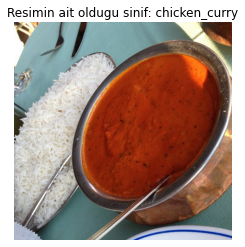

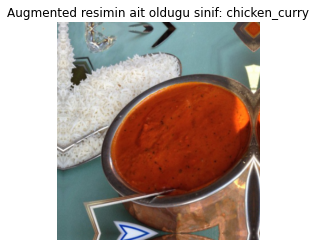

In [24]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# rasgele resimi alalim
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Resimin ait oldugu sinif: {target_class}")
plt.axis(False);

# augmented resime bakalim
augmented_img = data_augmentation(img,training=True)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255)
plt.title(f"Augmented resimin ait oldugu sinif: {target_class}")
plt.axis(False);
# print(augmented_img)

In [25]:
from tensorflow.keras import layers

**model_1** :verinin %1 i ile feature exraction transfer learning ve data augmentation kullanarak...

In [26]:
# inputlari ayarlayalim ve base model katmanlarini donduralim 
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# data augmentation i katman(layer) olarak ekleyelim
x = data_augmentation(inputs)

# base modele input olarak augmented(arttirilmis) veriyi veerelim ama training gerceklesmesin 
x = base_model(x, training=False)

# base model in ciktilarini pooling islemini tabii tutucaz cunku cok buyuk tensorler cikti verecek
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# bir dense katmani(layer)ni output icin koyalim
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# input ve outputlar ile modeli olusturalim
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                # Track model training logs
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20220313-150700
Epoch 1/5
3/3 [==============================] - 17s 4s/step - loss: 2.3950 - accuracy: 0.1286 - val_loss: 2.2360 - val_accuracy: 0.1826
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 2.1658 - accuracy: 0.2429 - val_loss: 2.1285 - val_accuracy: 0.2220
Epoch 3/5
3/3 [==============================] - 7s 3s/step - loss: 1.9646 - accuracy: 0.4429 - val_loss: 2.0058 - val_accuracy: 0.3026
Epoch 4/5
3/3 [==============================] - 5s 2s/step - loss: 1.7792 - accuracy: 0.4714 - val_loss: 1.9191 - val_accuracy: 0.3964
Epoch 5/5
3/3 [==============================] - 5s 2s/step - loss: 1.6417 - accuracy: 0.5571 - val_loss: 1.8226 - val_accuracy: 0.4737


modele bakalim

In [27]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

performansini degerlendirelim

In [28]:
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 11s 131ms/step - loss: 1.8335 - accuracy: 0.4352


[1.8335202932357788, 0.4352000057697296]

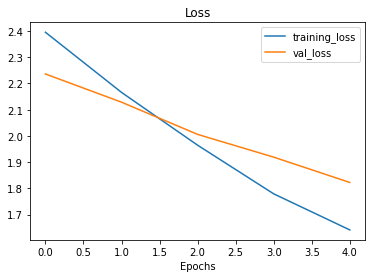

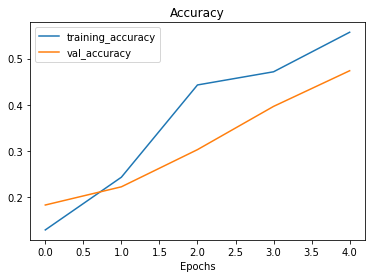

In [29]:
plot_loss_curves(history_1_percent)

### Model 2
model_2- verinin %10 u ile feature exraction transfer learning ve data augmentation kullanarak...

Artik gereksiz seyleri yazmadan geciyorum veriyi daha once indirmistik

In [30]:
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [31]:
#ne kadar verimiz var
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [32]:
#inputlari ayarlayalim
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [33]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

#data augmentation katmani
data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  layers.RandomZoom(0.2),
  layers.RandomRotation(0.2),
  # preprocessing.Rescaling(1./255)
], name="data_augmentation")

# input shape 
input_shape = (224, 224, 3)

#base modeli  tanimlayalim (backbone olarak da adlandirilir)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# tum girdi ve ciktilari modele oturtalim
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs) 
x = base_model(x, training=False) 
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [34]:
#modelimize bakalim
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2D (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

**ModelCheckpoint** olusturalim bu modelimizi kaydetmeyi ve nerde kaldiysak ordan devam edebilmemizi saglar. Yani egitimi bir asamada durdurup sonra kaldigi yerden devam edebilmemizi saglar. Modelinin tamamini veya sadece weight yani agirliklarini kaydetmemizi saglayabilir. Bunu model ogrenirken yani training asamasinda yapar.

In [35]:
# kaydedilecegi yolu ayarlayalim
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# olusturalim
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, #sadece agirliklari kaydedecek
                                                         save_best_only=False,
                                                         save_freq="epoch", # her epochta kaydetmek icin
                                                         verbose=1)

In [36]:
#deneyelim
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                 experiment_name="10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220313-150756
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0025 - accuracy: 0.3467
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 28s 853ms/step - loss: 2.0025 - accuracy: 0.3467 - val_loss: 1.4399 - val_accuracy: 0.7007
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.4067 - accuracy: 0.6453
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 17s 674ms/step - loss: 1.4067 - accuracy: 0.6453 - val_loss: 1.0289 - val_accuracy: 0.8010
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0561 - accuracy: 0.7360
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 14s 576ms/step - loss: 1.0561 - accuracy: 0.7360 - val_loss: 0.8535 - val_accuracy: 0.8158
E

In [37]:
#ilk modelimizn performansi nasildi
model_0.evaluate(test_data)

79/79 [==============================] - 11s 132ms/step - loss: 0.6166 - accuracy: 0.8340


[0.6165830492973328, 0.8339999914169312]

In [38]:
#model_2nin performansina bakalim
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 11s 136ms/step - loss: 0.6852 - accuracy: 0.8180


[0.6851955652236938, 0.8180000185966492]

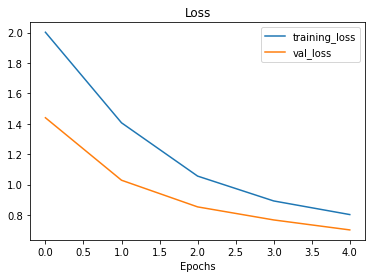

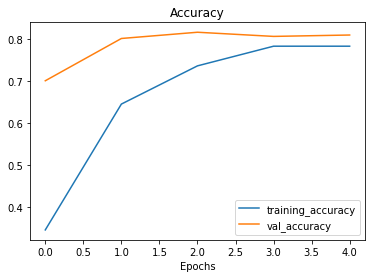

In [39]:
plot_loss_curves(history_10_percent_data_aug)

Istedigimiz Checkpoint ile modeli tekrar yukleyelim

In [39]:
#agirliklari alalim
model_2.load_weights(checkpoint_path)

tekrar yukledigimiz agirliklar ile modeli evaluate edelim ve onceki islem ile ayni sonuclar olup olmadigina bakalim

In [40]:
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 11s 133ms/step - loss: 0.6852 - accuracy: 0.8180


In [42]:
results_10_percent_data_aug == loaded_weights_model_results

True

tamamen ayni cikti ki oyle olmasi gerekiyordu, tamamen ayni cikmaz ise bile hesaplamadan dolayi olan cok ufak bir fark olacakti( 1/1.000.000 gibi)

## Model 3
model_3 - verinin %10 u ile **fine-tuning** transfer learning ve data augmentation kullanarak...

bu modelde EfficientNet mimarisindeki bazi katmanalari(layer) da egitilebilir kilacagiz.


**Not**: Genelde once Feature Extraction Modeli egitilir ardindan birkac epoch da buyuk bir veri setiyle Fine-Tuning yapilir.

In [43]:
#model_2 nin katmanlarina bakalim
model_2.layers 

In [44]:
#hangi katmanlar egitilebilir durumda ?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fcbc55e6650> True
<keras.engine.sequential.Sequential object at 0x7fcbc254c350> True
<keras.engine.functional.Functional object at 0x7fcbc1f23d90> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7fcbc1f8f410> True
<keras.layers.core.dense.Dense object at 0x7fcbc1f80490> True


Functional katmani yani base_model dedigimiz EfficientNet egitilebilir degil ,kontrol edelim

In [46]:
#kac degisken egitileilir durumda
print(len(model_2.layers[2].trainable_variables))

0


In [47]:
# base_model imizi egitilebilir yapalim
base_model.trainable = True

# son 10 layer(katman haric) hepsini tekrar donduralim
for layer in base_model.layers[:-10]:
  layer.trainable = False

# tekrar compile edelim 
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001), # fine tuning yaparken daha dusuk learning rate kullanilir genelde 10 kat dusuk
                metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


kac tane egitilebilir degisken var bakalim

In [49]:
 print(len(model_2.trainable_variables))

12


In [50]:
# 5 epoch daha egitelim
fine_tune_epochs = initial_epochs + 5


history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25 * len(test_data)),
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # en son hangi epochta kaldiysa ordan devam etsin
                                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                      experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20220313-152949
Epoch 5/10
24/24 [==============================] - 25s 675ms/step - loss: 0.7357 - accuracy: 0.7840 - val_loss: 0.5421 - val_accuracy: 0.8421
Epoch 6/10
24/24 [==============================] - 16s 649ms/step - loss: 0.6104 - accuracy: 0.8147 - val_loss: 0.5111 - val_accuracy: 0.8454
Epoch 7/10
24/24 [==============================] - 12s 494ms/step - loss: 0.5147 - accuracy: 0.8320 - val_loss: 0.5028 - val_accuracy: 0.8438
Epoch 8/10
24/24 [==============================] - 12s 497ms/step - loss: 0.4641 - accuracy: 0.8600 - val_loss: 0.4812 - val_accuracy: 0.8553
Epoch 9/10
24/24 [==============================] - 13s 518ms/step - loss: 0.4416 - accuracy: 0.8613 - val_loss: 0.4571 - val_accuracy: 0.8569
Epoch 10/10
24/24 [==============================] - 15s 609ms/step - loss: 0.3905 - accuracy: 0.8893 - val_loss: 0.4882 - val_accuracy: 0.8503


In [51]:
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 11s 133ms/step - loss: 0.4882 - accuracy: 0.8424


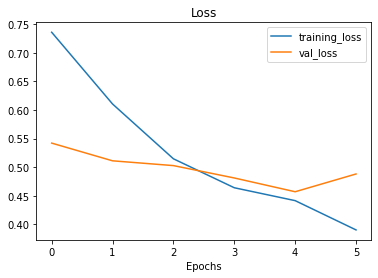

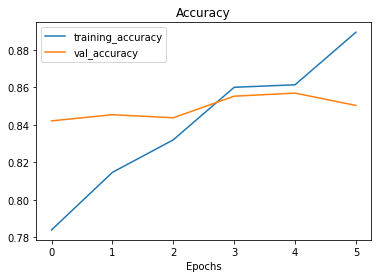

In [52]:
# Check out the loss curves of our fine-tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

modelleri karsilastirmak icin bir fonksiyon bulalim, bu fonksiyon bize fine-tuningin basladigi yerden itibaren de gelisimini gozlemlemek icin imkan saglicak

In [53]:
def compare_historys(original_history, new_history, initial_epochs=5):
  """
  Compares two TensorFlow History objects.
  """
  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history metrics with new_history metrics
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plot for accuracy
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Val Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  # Make plot for loss
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Val Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")

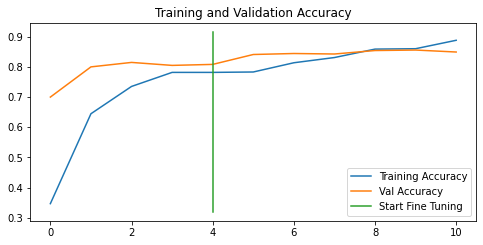

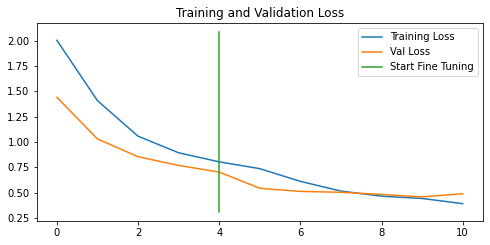

In [54]:
compare_historys(history_10_percent_data_aug,
                 history_fine_10_percent_data_aug,
                 initial_epochs=5)

## Model 4

model_4 - verinin %100 u ile fine-tuning transfer learning ve data augmentation kullanarak...

In [55]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2022-03-13 15:45:52--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.157.128, 108.177.125.128, 2404:6800:4008:c07::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.157.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   204MB/s    in 2.4s    

2022-03-13 15:45:55 (204 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [57]:
#klasorleri ayarlayalim
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [58]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 

In [59]:
#inputlari ayarlayalim
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [60]:
#eski model ile yeni test_data yi evalute edersek ayni sonuca ulasmamiz gerekir cunku test verisi ayni sadece trainig verisi farkli idi
model_2.evaluate(test_data)

79/79 [==============================] - 12s 144ms/step - loss: 0.4882 - accuracy: 0.8424


[0.4882476031780243, 0.8424000144004822]

In [61]:
#kontrol edelim
results_fine_tune_10_percent

[0.48824766278266907, 0.8424000144004822]

modeli tekrar feature extraction sonrasina getirip ordan tekrar tum veri ile egitecegiz o yuzden checkpointleri kullanarak agirliklarimizi tekrar alalim. Aksi halde fine-tuning uzerine tekrar yapmis olacagiz

In [66]:
model_2.load_weights(checkpoint_path)

tekrar evaluate ederek yaptigimizi dogrulayalim ve karsilastiralim

In [63]:
model_2.evaluate(test_data)

79/79 [==============================] - 11s 132ms/step - loss: 0.6852 - accuracy: 0.8180


[0.6851955056190491, 0.8180000185966492]

In [64]:
results_10_percent_data_aug 

[0.6851955652236938, 0.8180000185966492]

hangi katmanlar egitilebilir tekarar bakalim, ayni sekilde sadece son 10 katman egitilebilir durumda/

In [65]:
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [69]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [70]:
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                  experiment_name="full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20220313-160110
Epoch 5/10
235/235 [==============================] - 96s 371ms/step - loss: 0.7347 - accuracy: 0.7608 - val_loss: 0.4180 - val_accuracy: 0.8470
Epoch 6/10
235/235 [==============================] - 73s 308ms/step - loss: 0.5972 - accuracy: 0.8052 - val_loss: 0.3792 - val_accuracy: 0.8750
Epoch 7/10
235/235 [==============================] - 69s 290ms/step - loss: 0.5393 - accuracy: 0.8280 - val_loss: 0.3231 - val_accuracy: 0.9030
Epoch 8/10
235/235 [==============================] - 65s 273ms/step - loss: 0.4832 - accuracy: 0.8428 - val_loss: 0.3544 - val_accuracy: 0.8766
Epoch 9/10
235/235 [==============================] - 62s 263ms/step - loss: 0.4515 - accuracy: 0.8565 - val_loss: 0.3055 - val_accuracy: 0.8947
Epoch 10/10
235/235 [==============================] - 63s 267ms/step - loss: 0.4197 - accuracy: 0.8636 - val_loss: 0.3395 - val_accuracy: 0.8832


In [71]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 11s 131ms/step - loss: 0.3440 - accuracy: 0.8844


[0.3439679443836212, 0.8844000101089478]

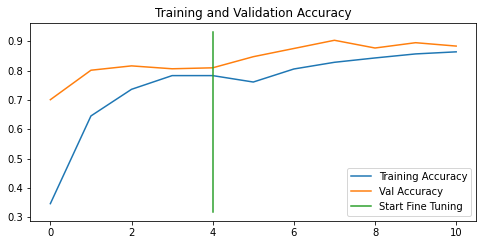

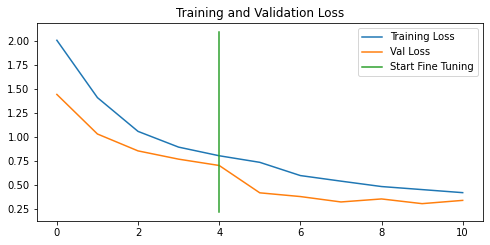

In [72]:
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

tensorboard uzerinde modellerimiz inceleyelemek icin 

In [ ]:
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer Learning Experiments with 10 Food101 Classes" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning." \
  --one_shot # exits the uploader once its finished uploading